# Prueba - Profesional III Analítica 
## Departamento de Analítica y Gestión de la Información

#### Julian Felipe Baquero Mesa | julianfbaquero@gmail.com
##### julio de 2019

In [1]:
#En primera instancia, importamos las librerías a usar en el desarrollo de la actividad
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


##### Lectura y análisis de las bases de datos

In [2]:
clientes = pd.read_csv("dav_data.csv")
data_men = pd.read_csv("datos_mesuales.csv")

* Primero revisaremos el tamaño de la base de datos de clientes y la naturaleza de sus variables, de esta forma se verifica que estén acordes con la información entregada en el enunciado

In [3]:
clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10693 entries, 0 to 10692
Data columns (total 19 columns):
CONSECUTIVO       10693 non-null int64
COMPRA_CARTERA    10693 non-null int64
EDAD              10655 non-null float64
ACIERTA           10689 non-null float64
QUANTO            10689 non-null float64
ACT_LAB           9737 non-null object
ANT_DAV           10691 non-null float64
SALDO_DAV_ANT     10693 non-null float64
SALDO_DAV_ACT     10693 non-null float64
CUPO_DAV          10689 non-null float64
ANT_SF            10691 non-null float64
SALDO_SF_ANT      10689 non-null float64
SALDO_SF_ACT      10691 non-null float64
CUPO_SF           10689 non-null float64
NUM_PROD_P1       10689 non-null float64
NUM_PROD_P2       10689 non-null float64
NUM_PROD_P3       10689 non-null float64
NUM_PROD_P4       10689 non-null float64
ENTIDAD_COMPRA    4677 non-null object
dtypes: float64(15), int64(2), object(2)
memory usage: 1.6+ MB


Se evidencia que el tamaño de la base es de 19 variables y 10693 entradas. Con base en esta información, podemos observar que las variables */ACT_LAB/* y */ENTIDAD_COMPRA/* son las que tienen menos entradas. En el caso de la variable */ENTIDAD_COMPRA/* es coherente que se tengan menos entradas, dado que solo aquellos clientes que efectivamente hayan recibidio la compra de cartera deben tener datos en esa variable. Sin embargo, en la variable */ACT_LAB/* no se evidencia alguna justificación para tener menos entradas de las esperadas, por lo tanto, se debe analizar la relevancia de esta variable y se debe encontrar un tratamiento especial. Del mismo modo se observa que las únicas variables que tienen la totalidad de las entradas son */CONSECUTIVO/*, */COMPRA_CARTERA/*, */SALDO_DAV_ANT/* y */SALDO_DAV_ACT/*. 

Frente a estas situaciones se puede actuar de varias formas. Por ejemplo, buscando la manera de completar los valores restantes en cada una de las variables o eliminando las filas que contengan valores nulos o faltantes. En este caso se toma decisión de completar la variable */ENTIDAD_COMPRA/* reemplazando los valores nulos por la cadena de texto "No aplica". De igual forma se procede a evaluar la variable */ACT_LAB/* para identificar el tratamiento adecuado y posteriormente eliminar las filas con valores restantes, dado que se cuenta con un cantidad superior a los 10.000 datos por lo cual se considera que existe amplia representación en los datos resultantes. 

Procedimiento a continuación:

In [4]:
#Primero reemplazamos los valores nulos de la variable ENTIDAD_COMPRA
clientes['ENTIDAD_COMPRA'].fillna('No aplica', inplace=True)
#Comprobamos la nueva cantidad de entradas
clientes['ENTIDAD_COMPRA'].shape

(10693,)

In [5]:
#Analizamos la variable de actividad laboral para identificar si existe algún motivo visible para tener valores nulos 
clientes[['CONSECUTIVO','ACT_LAB']].groupby(['ACT_LAB']).count()

,CONSECUTIVO
ACT_LAB,
E,7698
I,1915
P,124


In [6]:
#Calculamos cuántos valores nulos tiene esta variable
clientes['ACT_LAB'].isna().sum()

956

In [7]:
#Dado que son bastantes valores restantes, se hace uso del método backfill para completar las entradas
#Este método toma como referencia el siguiente valor válido para reemplazar cada valor nulo
clientes['ACT_LAB'].fillna(method = 'backfill', inplace=True)
#Verificamos si se realizaron los cambios
clientes[['CONSECUTIVO','ACT_LAB']].groupby(['ACT_LAB']).count()

,CONSECUTIVO
ACT_LAB,
E,8444
I,2116
P,133


Se evidencia que estas dos variables ya quedan completas en sus entradas y se procede a eliminar las filas con valores nulos

In [8]:
#Eliminamos y verificamos
clientes.dropna(inplace=True)
clientes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10655 entries, 0 to 10692
Data columns (total 19 columns):
CONSECUTIVO       10655 non-null int64
COMPRA_CARTERA    10655 non-null int64
EDAD              10655 non-null float64
ACIERTA           10655 non-null float64
QUANTO            10655 non-null float64
ACT_LAB           10655 non-null object
ANT_DAV           10655 non-null float64
SALDO_DAV_ANT     10655 non-null float64
SALDO_DAV_ACT     10655 non-null float64
CUPO_DAV          10655 non-null float64
ANT_SF            10655 non-null float64
SALDO_SF_ANT      10655 non-null float64
SALDO_SF_ACT      10655 non-null float64
CUPO_SF           10655 non-null float64
NUM_PROD_P1       10655 non-null float64
NUM_PROD_P2       10655 non-null float64
NUM_PROD_P3       10655 non-null float64
NUM_PROD_P4       10655 non-null float64
ENTIDAD_COMPRA    10655 non-null object
dtypes: float64(15), int64(2), object(2)
memory usage: 1.6+ MB


Se evidencia que ahora contamos con 10655 entradas y las mismas variables, ahora sin valores nulos.

Por otro lado, se observa que la variable */SCORE/* recibe el nombre de */ACIERTA/* y la variable */ING_EST/* recibe el nombre de */QUANTO/*. Por lo tanto, se deben ajustar sus nombres para mantenernos acordes con la información entregada. De igual forma, se evidencia que la única variable que no corresponde a las características entregadas es */EDAD/*, ya que vemos que se interpreta como una varaible numérica continua, pero en realidad es una variable categórica que redondea la edad a un número entero, por lo cual se debe ajustar.

A continuación se presentan los ajustes mencionados:

In [9]:
#Cambio de nombre de las variables
clientes.rename(columns={'ACIERTA':'SCORE',
                          'QUANTO':'ING_EST'}, 
                 inplace=True)
#Cambio de tipo de variable
clientes['EDAD'] = clientes['EDAD'].astype('int')
clientes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10655 entries, 0 to 10692
Data columns (total 19 columns):
CONSECUTIVO       10655 non-null int64
COMPRA_CARTERA    10655 non-null int64
EDAD              10655 non-null int32
SCORE             10655 non-null float64
ING_EST           10655 non-null float64
ACT_LAB           10655 non-null object
ANT_DAV           10655 non-null float64
SALDO_DAV_ANT     10655 non-null float64
SALDO_DAV_ACT     10655 non-null float64
CUPO_DAV          10655 non-null float64
ANT_SF            10655 non-null float64
SALDO_SF_ANT      10655 non-null float64
SALDO_SF_ACT      10655 non-null float64
CUPO_SF           10655 non-null float64
NUM_PROD_P1       10655 non-null float64
NUM_PROD_P2       10655 non-null float64
NUM_PROD_P3       10655 non-null float64
NUM_PROD_P4       10655 non-null float64
ENTIDAD_COMPRA    10655 non-null object
dtypes: float64(14), int32(1), int64(2), object(2)
memory usage: 1.6+ MB


* Ahora hacemos el mismo análisis para la base de datos mensuales

In [10]:
data_men.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42772 entries, 0 to 42771
Data columns (total 5 columns):
CONSECUTIVO    42772 non-null int64
mes_lag        42772 non-null int64
MORA_DAV       42772 non-null float64
MORA_SF        42772 non-null float64
NUM_CONS       42582 non-null float64
dtypes: float64(3), int64(2)
memory usage: 1.6 MB


En este caso se evidencia una base con 5 variables y 42772 entradas. De las cuales, la única que presenta valores nulos es */NUM_CONS/* que corresponde a las consultas en centrales de riesgo. Por lo tanto se decide reemplazar los valores nulos por el número 0.

In [11]:
data_men['NUM_CONS'].fillna(0, inplace=True)
data_men.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42772 entries, 0 to 42771
Data columns (total 5 columns):
CONSECUTIVO    42772 non-null int64
mes_lag        42772 non-null int64
MORA_DAV       42772 non-null float64
MORA_SF        42772 non-null float64
NUM_CONS       42772 non-null float64
dtypes: float64(3), int64(2)
memory usage: 1.6 MB


Se observan que las dos bases de datos quedan ajustadas y listas para el análisis descriptivo que nos permita entender las variables y plantear las primeras hipótesis 

##### Análisis descriptivo

In [12]:
#Evaluamos las estadísticas básicas de las variables con el fin de identificar posibles variables con outliers
clientes.describe()

,CONSECUTIVO,COMPRA_CARTERA,EDAD,SCORE,ING_EST,ANT_DAV,SALDO_DAV_ANT,SALDO_DAV_ACT,CUPO_DAV,ANT_SF,SALDO_SF_ANT,SALDO_SF_ACT,CUPO_SF,NUM_PROD_P1,NUM_PROD_P2,NUM_PROD_P3,NUM_PROD_P4
count,10655.000000,10655.000000,10655.000000,10655.000000,10655.000000,10655.000000,10655.000000,10655.000000,10655.000000,10655.000000,1.065500e+04,1.065500e+04,10655.000000,10655.000000,10655.000000,10655.000000,10655.000000
mean,5345.461380,0.437260,43.870483,737.577945,6659.856687,5.923703,12588.880171,9110.547983,15908.939277,6.522612,3.595684e+04,4.250566e+04,15908.939277,0.423182,1.551384,0.666072,0.798123
std,3086.143252,0.496071,12.583154,143.269824,5952.895762,7.791940,20860.962656,18812.444806,26193.547675,6.242151,2.286577e+05,2.355356e+05,26193.547675,1.102622,2.240756,0.835205,1.281072
min,1.000000,0.000000,20.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2675.500000,0.000000,32.000000,697.000000,2699.000000,1.170000,2137.890000,718.430000,1299.000000,1.830000,4.245000e+02,1.402500e+03,1299.000000,0.000000,0.000000,0.000000,0.000000
50%,5344.000000,0.000000,40.000000,779.000000,4488.000000,2.750000,5115.000000,2303.750000,6499.000000,5.080000,6.243000e+03,1.021300e+04,6499.000000,0.000000,1.000000,0.000000,0.000000
75%,8016.500000,1.000000,50.000000,836.000000,8641.000000,7.580000,13542.160000,9026.500000,19309.500000,9.830000,3.017700e+04,3.973000e+04,19309.500000,0.000000,2.000000,1.000000,1.000000
max,10693.000000,1.000000,70.000000,942.000000,71143.000000,55.250000,360538.000000,360044.000000,545000.000000,49.170000,1.502828e+07,1.504157e+07,545000.000000,12.000000,40.000000,7.000000,41.000000


Identificamos 4 variables que posiblemente tienen valores atípicos, por lo tanto vamos a evaluar gráficamente para comprobar:

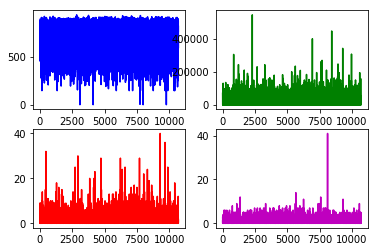

In [13]:
#Cosntrucción de la figura con las cuatro gráficas
plt.figure
plt.subplot(2,2,1)
plt.plot(clientes['CONSECUTIVO'],clientes['SCORE'],'b')
plt.subplot(2,2,2)
plt.plot(clientes['CONSECUTIVO'],clientes['CUPO_DAV'],'g')
plt.subplot(2,2,3)
plt.plot(clientes['CONSECUTIVO'],clientes['NUM_PROD_P2'],'r')
plt.subplot(2,2,4)
plt.plot(clientes['CONSECUTIVO'],clientes['NUM_PROD_P4'],'m')

De acuerdo con las gráficas se tienen las siguientes observaciones:
    - SCORE(azul): Se evidencian 5 observaciones con valor cercano a 0, lo cual es atipico a la luz que el percentil 25 es de 697. Por lo tanto es necesario hacer un tratamiento a estos datos para ajustar sus valores.
    - CUPO_DAV(verde): Se evidencian clientes con cupos superiores a los 300 millones de pesos, lo cual es posible, pero se se debe prestar atención al impacto que tenga esta variable en la construcción del modelo
    - NUM_PROD_P2(rojo): Se evidencia que en esta variable existe un grupo de clientes con más de 20 productos en la entidad 2 del sistema financiero, estos se consideran datos atípicos. Si observamos los percentiles, vemos que el percentil 75 de esta variable es 2. Esto quiere decir que el 75% de los clientes tienen máximo 2 productos en esta entidad, po lo cual, esos valores tan altos representan una anomalía.
    - NUM_PROD_P4(magenta): Se evidencia un comportamiento similar al de al variable anterior, con la diferencia de que esta variable presenta menos datos atípicos.

Con base en este análisis se plantea reemplazar los datos atípicos de la siguiente forma:

In [14]:
#Reemplazamos todos los outliers de la variable SCORE por la mediana
median = clientes.loc[clientes['SCORE']>200, 'SCORE'].median()
clientes['SCORE'] = np.where(clientes['SCORE'] <200, median,clientes['SCORE'])

In [15]:
#Para el tratamiento de las variables NUM_PROD_P2 y NUM_PROD_P4 decidimos tener como referencia las variables 
#NUM_PROD_P1 y NUM_PROD_P3 que tienen como valores máximos 12 y 7 respectivamente.

clientes['NUM_PROD_P2'] = np.where(clientes['NUM_PROD_P2'] >12, 12,clientes['NUM_PROD_P2'])
clientes['NUM_PROD_P4'] = np.where(clientes['NUM_PROD_P4'] >7, 7,clientes['NUM_PROD_P4'])


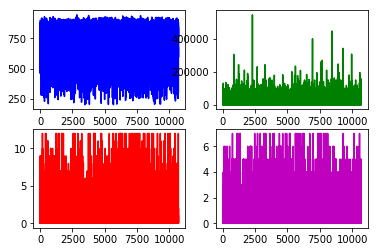

In [16]:
#Graficamos de nuevo para comprobar el efecto de los cambios realizados
plt.figure
plt.subplot(2,2,1)
plt.plot(clientes['CONSECUTIVO'],clientes['SCORE'],'b')
plt.subplot(2,2,2)
plt.plot(clientes['CONSECUTIVO'],clientes['CUPO_DAV'],'g')
plt.subplot(2,2,3)
plt.plot(clientes['CONSECUTIVO'],clientes['NUM_PROD_P2'],'r')
plt.subplot(2,2,4)
plt.plot(clientes['CONSECUTIVO'],clientes['NUM_PROD_P4'],'m')

Tal como se esperaba, las 3 variables ajustadas ya no presentan valores atípicos y la variable del cupo en Davivienda se mantiene y vamos a realizar un análisis adicional para evaluar su comportamiento.

Como complemento al análisis, vamos a graficar la matriz de correlaciones para todas las variables de la base de clientes:

Text(0.5, 1.05, 'Correlation Matrix')

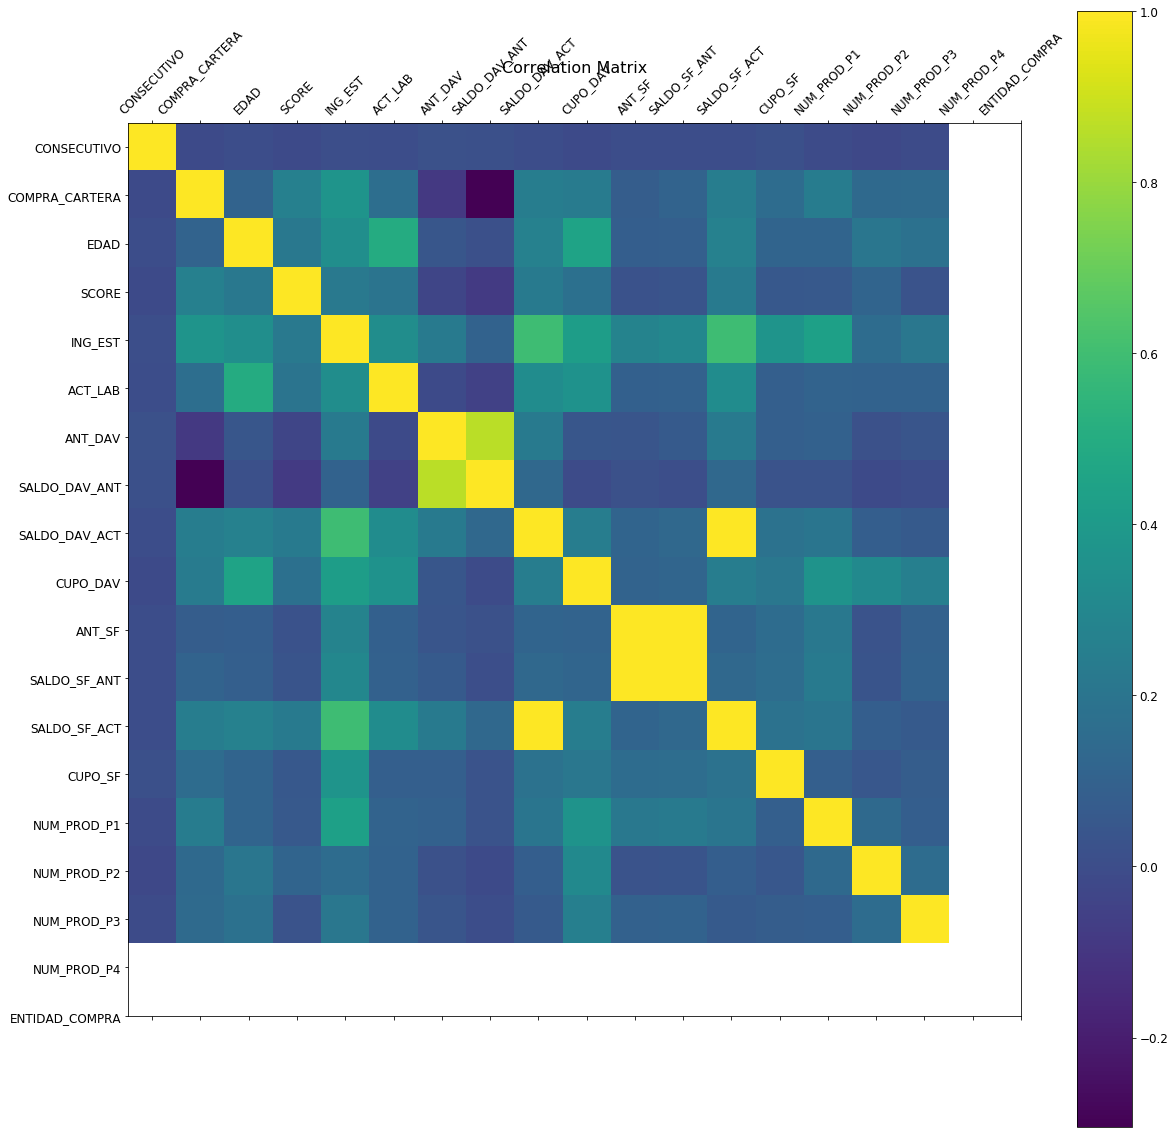

In [17]:
#Vamos a graficar la matriz de correlación para todas las variables de la base de datos de clientes
f = plt.figure(figsize=(20, 20))
plt.matshow(clientes.corr(), fignum=f.number)
plt.xticks(range(clientes.shape[1]), clientes.columns, fontsize=12, rotation=45)
plt.yticks(range(clientes.shape[1]), clientes.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title('Correlation Matrix', fontsize=16)

Como primer hallazgo tenemos que las variables */CONSECUTIVO/* y */ENTIDAD_COMPRA/* no presentan ninguna correlación con las demás variables. Esto nos indica que no existe relación entre el número asignado a cada cliente y ninguna variable, por lo tanto, podemos entender que a pesar de tener una variable ordenada, este orden no tiene influencia de ninguna variable. 
en cuanto a la variable */ENTIDAD_COMPRA/* podemos observar que no se presentan datos de correlación dado que es una variable categórica que no marca ninguna tendencia.

Si retomamos el análisis que estabamos realizando sobre la variable */NUM_PROD_P4/* vemos que existe una correlación positiva con los ingresos estimados y el número de productos en otras entidades del sector. De esta forma concluimos que existe coherencia en los datos presentados y podemos mantener los atípicos en esta variable.

También se hace evidente un fuerte correlación negativa entre las variables */COMPRA_CARTERA/* y */SALDO_DAV_ACT/*, lo cual nos lleva a plantear que los clientes más susceptibles a la compra de cartera son aquellos que presentan un bajo saldo con Davivienda.

Otra de las correlaciones que sobre salen visualmente se da entre las variables que marcan el saldo actual en Davivienda y el saldo actual en el sector financiero, lo que se entiende perfectamente como un comportamiento natural de las variables. Sin embargo, esta correlación también nos permite pensar en una nueva variable que nos permita calcular el saldo actual por fuera de nuestra entidad, la cual se construiría por medio de la diferencia entre el saldo con el sector financiero y el saldo con Davivienda. 

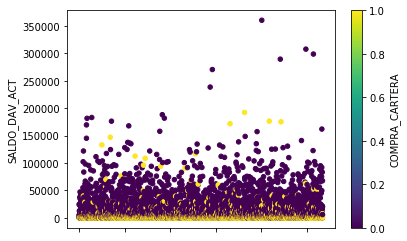

In [18]:
#Realizamos otra gráfica para evaluar la relación entre la compra de cartera y el saldo actual con Davivienda, de acuerdo con nuestra hipótesis

clientes.plot(kind='scatter', x='CONSECUTIVO',y='SALDO_DAV_ACT',c='COMPRA_CARTERA',colormap='viridis')


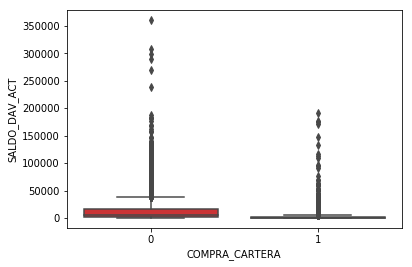

In [19]:
sns.boxplot(y='SALDO_DAV_ACT',x='COMPRA_CARTERA',data=clientes, palette="Set1")

#sns.boxplot(x="day", y="total_bill", hue="smoker", data=df, palette="Set1")



In [20]:
clientes[['CONSECUTIVO','COMPRA_CARTERA']].groupby(['COMPRA_CARTERA']).count()

,CONSECUTIVO
COMPRA_CARTERA,
0,5996
1,4659


De acuerdo con las gráficas anteriores y el conteo de clientes a los cuales les han comprado cartera, vemos que no existe evidencia estadística suficiente para asegurar una correlación entre las dos variables. Sin embargo, vemos que existen más clientes a los cuales no se les ha comprado cartera y estos clientes tienden a presentar un mayor saldo en Davivienda, por encima de a quienes sí se les ha comprado la cartera. Es decir quer tenemos una base de datos desbalanceada con respecto a la variable resultado. Sin embargo, vamos a asumir este desbalanceo para construir el modelo y en caso de ser necesario buscaremos un método de balanceo.

A continuación presentamos una revisión de la variable */ENTIDAD_COMPRA/* para evaluar si es necesario hacer un tratamiento adicional de acuerdo con su comportamiento:

In [21]:
clientes[['CONSECUTIVO','ENTIDAD_COMPRA','COMPRA_CARTERA']].groupby(['ENTIDAD_COMPRA','COMPRA_CARTERA']).count()

,,CONSECUTIVO
ENTIDAD_COMPRA,COMPRA_CARTERA,
No aplica,0,5996
P1,1,805
P2,1,2613
P3,1,492
P4,1,749


De acuerdo con tabla presentada se hace evidente que la entidad 2 es la que más compras de cartera ha realizado y la entidad 3 la que menos. De igual forma se comprueba que los clientes que los valores nulos de esta variable fueron reemplazados correctamente y equivalen al total de los clientes que no han recibido una compra de cartera *5996*

##### Preparación de las variables para el modelo inicial

Se plantea la creación de una nueva variable y el tratamiento de las variables categóricas para contemplarlas en la construcción del modelo

In [22]:
#Creacion de la variable que calcula el endeudamiento actual fuera de Davivienda

clientes['SAL_OUT_DAV'] = clientes['SALDO_SF_ACT'] - clientes['SALDO_DAV_ACT']
clientes.head()

,CONSECUTIVO,COMPRA_CARTERA,EDAD,SCORE,ING_EST,ACT_LAB,ANT_DAV,SALDO_DAV_ANT,SALDO_DAV_ACT,CUPO_DAV,ANT_SF,SALDO_SF_ANT,SALDO_SF_ACT,CUPO_SF,NUM_PROD_P1,NUM_PROD_P2,NUM_PROD_P3,NUM_PROD_P4,ENTIDAD_COMPRA,SAL_OUT_DAV
0,1,1,50,894.0,14227.0,I,3.08,6884.26,3092.32,68900.0,14.17,0.0,3742.0,68900.0,0.0,2.0,1.0,1.0,P2,649.68
1,2,1,60,654.0,8322.0,E,14.08,3504.91,1534.87,5599.0,10.67,100351.0,123119.0,5599.0,1.0,1.0,0.0,0.0,P1,121584.13
2,3,0,40,806.0,1681.0,E,4.50,1231.00,1637.00,0.0,3.42,0.0,13500.0,0.0,1.0,0.0,0.0,1.0,No aplica,11863.00
3,4,1,40,807.0,12661.0,E,1.50,13282.84,1360.74,11999.0,12.25,140353.0,194166.0,11999.0,1.0,9.0,2.0,1.0,P2,192805.26
4,5,0,50,823.0,1697.0,E,0.92,1019.00,1019.00,1999.0,0.50,14078.0,14236.0,1999.0,0.0,1.0,0.0,0.0,No aplica,13217.00


Debemos hacer un tratamiento adicional a las variables */ENTIDAD_COMPRA/* y */ACT_LAB/*, dado que son variables categóricas, vamos a hacer uso de la función *get_dummies* y de esta forma obtendremos variables numéricas. Esta función crea nuevas variables dicotómicas, tantas como posibles valores en cada variable.

In [23]:
#Usamos la función para las dos variables y comprobamos los cambios realizados
clientes = pd.get_dummies(data=clientes,columns=['ACT_LAB','ENTIDAD_COMPRA'])
clientes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10655 entries, 0 to 10692
Data columns (total 26 columns):
CONSECUTIVO                 10655 non-null int64
COMPRA_CARTERA              10655 non-null int64
EDAD                        10655 non-null int32
SCORE                       10655 non-null float64
ING_EST                     10655 non-null float64
ANT_DAV                     10655 non-null float64
SALDO_DAV_ANT               10655 non-null float64
SALDO_DAV_ACT               10655 non-null float64
CUPO_DAV                    10655 non-null float64
ANT_SF                      10655 non-null float64
SALDO_SF_ANT                10655 non-null float64
SALDO_SF_ACT                10655 non-null float64
CUPO_SF                     10655 non-null float64
NUM_PROD_P1                 10655 non-null float64
NUM_PROD_P2                 10655 non-null float64
NUM_PROD_P3                 10655 non-null float64
NUM_PROD_P4                 10655 non-null float64
SAL_OUT_DAV                 10

In [24]:
clientes.head()

,CONSECUTIVO,COMPRA_CARTERA,EDAD,SCORE,ING_EST,ANT_DAV,SALDO_DAV_ANT,SALDO_DAV_ACT,CUPO_DAV,ANT_SF,...,NUM_PROD_P4,SAL_OUT_DAV,ACT_LAB_E,ACT_LAB_I,ACT_LAB_P,ENTIDAD_COMPRA_No aplica,ENTIDAD_COMPRA_P1,ENTIDAD_COMPRA_P2,ENTIDAD_COMPRA_P3,ENTIDAD_COMPRA_P4
0,1,1,50,894.0,14227.0,3.08,6884.26,3092.32,68900.0,14.17,...,1.0,649.68,0,1,0,0,0,1,0,0
1,2,1,60,654.0,8322.0,14.08,3504.91,1534.87,5599.0,10.67,...,0.0,121584.13,1,0,0,0,1,0,0,0
2,3,0,40,806.0,1681.0,4.50,1231.00,1637.00,0.0,3.42,...,1.0,11863.00,1,0,0,1,0,0,0,0
3,4,1,40,807.0,12661.0,1.50,13282.84,1360.74,11999.0,12.25,...,1.0,192805.26,1,0,0,0,0,1,0,0
4,5,0,50,823.0,1697.0,0.92,1019.00,1019.00,1999.0,0.50,...,0.0,13217.00,1,0,0,1,0,0,0,0


De acuerdo con las últimas dos tablas vemos que ya tenemos las variables listas para iniciar la construcción del modelo

###### Construcción del modelo

En primera instancia creamos las variables del modelo y luego creamos conjuntos de datos para entrenamiento y prueba del modelo a construir

In [25]:
#Definimos las variables que van a ingresar al modelo
X = clientes.drop(['COMPRA_CARTERA'],axis=1)
y = clientes['COMPRA_CARTERA']
#Usamos la funcion split para crear dos conjuntos de datos para entrenamiento y prueba del modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Para encontrar el mejor modelo que estime los clientes que van a ser susceptibles de compra de cartera por parte de otras entidades, se propone evaluar los siguientes modelos:
- Regresión logística
- Árbol de decisión
- Random forest


Con los 3 modelos se puede realizar la clasificación de los clientes, en este caso con una variable dicotómica que indique si el cliente es o no susceptible a compra de cartera.
Para todos los modelos dejamos los parámetros que trae por defecto este paquete, el único parámetro que ajustamos en el árbol de decisión y el random forest es la semilla aleatoria con el fin de poder comprobar y comparar los resultados, de otro forma tendríamos respuestas distintas en cada corrida del modelo.


In [26]:
#Definimos los modelos que vamos a probar
LR=LogisticRegression()
DTR= DecisionTreeClassifier(random_state=42)
RFC=RandomForestClassifier(random_state=42)

In [27]:
#Ajustamos todos los modelos
LR.fit(X_train, y_train)
DTR.fit(X_train, y_train)
RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [28]:
#Predecimos con cada modelo
y_pred_LR = LR.predict(X_test)
y_pred_DTR = DTR.predict(X_test)
y_pred_RFC = RFC.predict(X_test)

Una vez se ajusten los modelos y se haga la predicción, planteamos evaluar el desempeño por medio de las métricas de accuracy, F1-score y F-beta score.
- El accuracy mide la relación entre la suma de los verdaderos negativos y verdaderos positivos cobre el total de las observaciones.
- El F1-score mide la relación entre el producto de la precisión y el recall y la suma de la precisión y el recall. Entendiendo precisión como la relación entre verdaderos positivos y la suma de los verdaderos positivos y falsos positivos, y el recall como la relación entre los verdaderos positivos y la suma de verdaderos positivos y falsos negativos.
- el F-beta score tiene una medida similiar al F1-score con la diferencia que esta métrica contempla un parámetro beta que indica el peso que se otorga a que el modelo seleccione verdaderos postivos en los resultados que calcula.


In [29]:
dict_res = {'Metodo':'LogisticRegression','Accuracy':metrics.accuracy_score(y_test, y_pred_LR) ,'F1-Score':metrics.f1_score(y_test, y_pred_LR),'F_Beta-Score':metrics.fbeta_score(y_test, y_pred_LR,beta=10)}
res = pd.DataFrame([dict_res], columns=dict_res.keys())

In [30]:
dict_res = {'Metodo':'DecisionTreeClassifier','Accuracy':metrics.accuracy_score(y_test, y_pred_DTR) ,'F1-Score':metrics.f1_score(y_test, y_pred_DTR),'F_Beta-Score':metrics.fbeta_score(y_test, y_pred_DTR,beta=10)}
res1 = pd.DataFrame([dict_res], columns=dict_res.keys())
res=res.append(res1, ignore_index = True)

In [31]:
dict_res = {'Metodo':'RandomForestClassifier','Accuracy':metrics.accuracy_score(y_test, y_pred_RFC) ,'F1-Score':metrics.f1_score(y_test, y_pred_RFC),'F_Beta-Score':metrics.fbeta_score(y_test, y_pred_RFC,beta=10)}
res1 = pd.DataFrame([dict_res], columns=dict_res.keys())
res=res.append(res1, ignore_index = True)

In [32]:
res

,Metodo,Accuracy,F1-Score,F_Beta-Score
0,LogisticRegression,0.934685,0.922113,0.912504
1,DecisionTreeClassifier,1.000000,1.000000,1.000000
2,RandomForestClassifier,1.000000,1.000000,1.000000


Tal como se muestra, se construyó una tabla para visualizar las métricas de los tres modelos y poder comparar fácilmente. Esta tabla nos muestra que tanto el árbol de decisión como el random forest obtienen valores de 1 para todas las métricas, lo cual quiere decir que aciertan con el 100% en sus resultados. Esto resulta algo poco probable y es una alarma sobre las variables que están conformando estos modelos. Por lo tanto, proponemos evaluar la importancia que se está dando a cada varaible para identificar cuál de estas puede estar sesgando el modelo:

In [33]:
feature_cols = X.columns
feature_cols

Index(['CONSECUTIVO', 'EDAD', 'SCORE', 'ING_EST', 'ANT_DAV', 'SALDO_DAV_ANT',
       'SALDO_DAV_ACT', 'CUPO_DAV', 'ANT_SF', 'SALDO_SF_ANT', 'SALDO_SF_ACT',
       'CUPO_SF', 'NUM_PROD_P1', 'NUM_PROD_P2', 'NUM_PROD_P3', 'NUM_PROD_P4',
       'SAL_OUT_DAV', 'ACT_LAB_E', 'ACT_LAB_I', 'ACT_LAB_P',
       'ENTIDAD_COMPRA_No aplica', 'ENTIDAD_COMPRA_P1', 'ENTIDAD_COMPRA_P2',
       'ENTIDAD_COMPRA_P3', 'ENTIDAD_COMPRA_P4'],
      dtype='object')

In [34]:
pd.DataFrame({'feature':feature_cols, 'importance':RFC.feature_importances_}).sort_values('importance',ascending=False)

,feature,importance
20,ENTIDAD_COMPRA_No aplica,0.429889
16,SAL_OUT_DAV,0.189553
22,ENTIDAD_COMPRA_P2,0.112468
6,SALDO_DAV_ACT,0.042532
21,ENTIDAD_COMPRA_P1,0.039742
24,ENTIDAD_COMPRA_P4,0.032719
23,ENTIDAD_COMPRA_P3,0.027696
5,SALDO_DAV_ANT,0.025780
3,ING_EST,0.020327
10,SALDO_SF_ACT,0.017606


De acuerdo con el listado de importancia de las variables, podemos ver que las variables que indican qué entidad ha comprado la cartera de ese cliente tienen mayor peso para el modelo random forest. Por lo tanto, se plantea crear un nuevo modelo ajustado.

##### Modelo ajustado

Creamos un modelo que no contemple las variables sobre las entidades que han comparado la cartera, dado que esas variables traes implicita la información sobre los clientes que efectivamente han tenido una compra de cartera

In [35]:
#Definimos las variables que van a ingresar al modelo
X_2 = clientes.drop(['COMPRA_CARTERA','ENTIDAD_COMPRA_No aplica', 'ENTIDAD_COMPRA_P1', 'ENTIDAD_COMPRA_P2',
       'ENTIDAD_COMPRA_P3', 'ENTIDAD_COMPRA_P4'],axis=1)
y = clientes['COMPRA_CARTERA']
#Usamos la funcion split para crear dos conjuntos de datos para entrenamiento y prueba del modelo
X_train_2, X_test_2, y_train, y_test = train_test_split(X_2, y, random_state=42)

In [36]:
#Definimos los modelos que vamos a probar
LR=LogisticRegression()
DTR= DecisionTreeClassifier(random_state=42)
RFC=RandomForestClassifier(random_state=42)

In [37]:
#Ajustamos todos los modelos
LR.fit(X_train_2, y_train)
DTR.fit(X_train_2, y_train)
RFC.fit(X_train_2, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [38]:
#Predecimos con cada modelo
y_pred_LR = LR.predict(X_test_2)
y_pred_DTR = DTR.predict(X_test_2)
y_pred_RFC = RFC.predict(X_test_2)

In [39]:
dict_res = {'Metodo':'LogisticRegression','Accuracy':metrics.accuracy_score(y_test, y_pred_LR) ,'F1-Score':metrics.f1_score(y_test, y_pred_LR),'F_Beta-Score':metrics.fbeta_score(y_test, y_pred_LR,beta=10)}
res = pd.DataFrame([dict_res], columns=dict_res.keys())

In [40]:
dict_res = {'Metodo':'DecisionTreeClassifier','Accuracy':metrics.accuracy_score(y_test, y_pred_DTR) ,'F1-Score':metrics.f1_score(y_test, y_pred_DTR),'F_Beta-Score':metrics.fbeta_score(y_test, y_pred_DTR,beta=10)}
res1 = pd.DataFrame([dict_res], columns=dict_res.keys())
res=res.append(res1, ignore_index = True)

In [41]:
dict_res = {'Metodo':'RandomForestClassifier','Accuracy':metrics.accuracy_score(y_test, y_pred_RFC) ,'F1-Score':metrics.f1_score(y_test, y_pred_RFC),'F_Beta-Score':metrics.fbeta_score(y_test, y_pred_RFC,beta=10)}
res1 = pd.DataFrame([dict_res], columns=dict_res.keys())
res=res.append(res1, ignore_index = True)

In [42]:
res

,Metodo,Accuracy,F1-Score,F_Beta-Score
0,LogisticRegression,0.931682,0.918386,0.907220
1,DecisionTreeClassifier,0.963964,0.957409,0.955747
2,RandomForestClassifier,0.960210,0.953014,0.952187


De acuerdo con el modelo ajustado, vemos que las métricas toman nuevos valores. Todos estos por encima del 90% y siendo el modelo de árbol de decisión el que ha obtenido los mejores resultados para todas las métricas. Con lo cual vamos encontrando cuál sería el modelo que tendría mejor desempeño. De nuevo buscamos evaluar cuáles variables tienen mayor importancia para este modelo a continuación:

In [43]:
feature_cols = X_2.columns
feature_cols

Index(['CONSECUTIVO', 'EDAD', 'SCORE', 'ING_EST', 'ANT_DAV', 'SALDO_DAV_ANT',
       'SALDO_DAV_ACT', 'CUPO_DAV', 'ANT_SF', 'SALDO_SF_ANT', 'SALDO_SF_ACT',
       'CUPO_SF', 'NUM_PROD_P1', 'NUM_PROD_P2', 'NUM_PROD_P3', 'NUM_PROD_P4',
       'SAL_OUT_DAV', 'ACT_LAB_E', 'ACT_LAB_I', 'ACT_LAB_P'],
      dtype='object')

In [44]:
pd.DataFrame({'feature':feature_cols, 'importance':DTR.feature_importances_}).sort_values('importance',ascending=False)

,feature,importance
16,SAL_OUT_DAV,0.430155
5,SALDO_DAV_ANT,0.277546
6,SALDO_DAV_ACT,0.227407
9,SALDO_SF_ANT,0.014100
0,CONSECUTIVO,0.009312
3,ING_EST,0.006477
7,CUPO_DAV,0.005129
11,CUPO_SF,0.004649
4,ANT_DAV,0.004517
2,SCORE,0.004273


Podemos observar que las variables que indican el saldo del cliente tanto en Davivienda como en el sector en general, en el mes actual y el anterior, son las que tienen mayor peso y en conjunto superan el 50% de la importancia total.

De acuerdo con el planteamiento de la actividad, se propone la creación de variables adicionales para incluirlas en el modelo.

##### Creación de variables para el modelo ajustado

In [45]:
data_men.head(15)

,CONSECUTIVO,mes_lag,MORA_DAV,MORA_SF,NUM_CONS
0,1,0,0.0,0.0,2.0
1,1,1,0.0,0.0,2.0
2,1,2,0.0,0.0,3.0
3,1,3,0.0,0.0,3.0
4,2,0,0.0,0.0,2.0
5,2,1,0.0,0.0,0.0
6,2,2,0.0,0.0,0.0
7,2,3,0.0,0.0,0.0
8,3,0,0.0,0.0,1.0
9,3,1,0.0,0.0,4.0


Buscamos crear un nuevo conjunto de datos que nos permita crear variables por cada mes para luego unir estos datos con la base de clientes y luego incluirlas en el modelo desarrollado.

Como primera medida creamos las variables dicotómicas que nos indican a qué corresponden los datos de cada una de las filas:

In [46]:
data_men = pd.get_dummies(data=data_men,columns=['mes_lag'])
data_men.head(15)

,CONSECUTIVO,MORA_DAV,MORA_SF,NUM_CONS,mes_lag_0,mes_lag_1,mes_lag_2,mes_lag_3
0,1,0.0,0.0,2.0,1,0,0,0
1,1,0.0,0.0,2.0,0,1,0,0
2,1,0.0,0.0,3.0,0,0,1,0
3,1,0.0,0.0,3.0,0,0,0,1
4,2,0.0,0.0,2.0,1,0,0,0
5,2,0.0,0.0,0.0,0,1,0,0
6,2,0.0,0.0,0.0,0,0,1,0
7,2,0.0,0.0,0.0,0,0,0,1
8,3,0.0,0.0,1.0,1,0,0,0
9,3,0.0,0.0,4.0,0,1,0,0


Creamos 4 conjuntos de datos para cada mes y luego procedemos a ajustarlos para preparar la unión con la base de datos de clientes:

In [47]:
d0 = data_men.loc[data_men['mes_lag_0'] == 1]
d1 = data_men.loc[data_men['mes_lag_1'] == 1]
d2 = data_men.loc[data_men['mes_lag_2'] == 1]
d3 = data_men.loc[data_men['mes_lag_3'] == 1]

In [48]:
#Cambio de nombre de las variables
d0.rename(columns={'MORA_DAV':'MORA_DAV_0', 'MORA_SF':'MORA_SF_0', 'NUM_CONS':'NUM_CONS_0'}, 
                 inplace=True)
d1.rename(columns={'MORA_DAV':'MORA_DAV_1', 'MORA_SF':'MORA_SF_1', 'NUM_CONS':'NUM_CONS_1'}, 
                 inplace=True)
d2.rename(columns={'MORA_DAV':'MORA_DAV_2', 'MORA_SF':'MORA_SF_2', 'NUM_CONS':'NUM_CONS_2'}, 
                 inplace=True)
d3.rename(columns={'MORA_DAV':'MORA_DAV_3', 'MORA_SF':'MORA_SF_3', 'NUM_CONS':'NUM_CONS_3'}, 
                 inplace=True)

In [49]:
#Solo dejamos las variables necesarias
d0 = d0.drop([ 'mes_lag_0','mes_lag_1', 'mes_lag_2', 'mes_lag_3'],axis=1)
d1 = d1.drop([ 'mes_lag_0','mes_lag_1', 'mes_lag_2', 'mes_lag_3'],axis=1)
d2 = d2.drop([ 'mes_lag_0','mes_lag_1', 'mes_lag_2', 'mes_lag_3'],axis=1)
d3 = d3.drop([ 'mes_lag_0','mes_lag_1', 'mes_lag_2', 'mes_lag_3'],axis=1)

In [50]:
#Creamos un solo conjunto de datos
data_0 = pd.merge(d0,d1, how ='inner', on ='CONSECUTIVO')
data_1 = pd.merge(data_0,d2, how ='inner', on ='CONSECUTIVO')
data_2 = pd.merge(data_1,d3, how ='inner', on ='CONSECUTIVO')
data_2.head()


,CONSECUTIVO,MORA_DAV_0,MORA_SF_0,NUM_CONS_0,MORA_DAV_1,MORA_SF_1,NUM_CONS_1,MORA_DAV_2,MORA_SF_2,NUM_CONS_2,MORA_DAV_3,MORA_SF_3,NUM_CONS_3
0,1,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,3.0
1,2,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,3.0
3,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


Con base en los datos del nuevo conjunto, creamos las variables propuestas y dos variables adicionales que pueden traer información relevante para nuestro caso de estudio y podemos incluirlas en el modelo.

In [51]:
#Construimos varaible dicotomica que indica si el cliente ha estado en mora en alguno de los ultimos 3 meses
#Variable para el banco
data_2['MORA_DAV'] = np.where(data_2['MORA_DAV_0']+data_2['MORA_DAV_1']+data_2['MORA_DAV_2']+data_2['MORA_DAV_3']>0,1,0)

#Variable sector financiero
data_2['MORA_SF'] = np.where(data_2['MORA_SF_0']+data_2['MORA_SF_1']+data_2['MORA_SF_2']+data_2['MORA_SF_3']>0,1,0)

#Creamos la variable que indica si el cliente ha tenido consultas en los últimos 3 meses
data_2['CONS'] = np.where(data_2['NUM_CONS_0']+data_2['NUM_CONS_1']+data_2['NUM_CONS_2']+data_2['NUM_CONS_3']>0,1,0)

#Creamos la variable que cuenta el número de consultas en los últimos 3 meses
data_2['NUM_CONS'] = data_2['NUM_CONS_0']+data_2['NUM_CONS_1']+data_2['NUM_CONS_2']+data_2['NUM_CONS_3']


data_2.head()

,CONSECUTIVO,MORA_DAV_0,MORA_SF_0,NUM_CONS_0,MORA_DAV_1,MORA_SF_1,NUM_CONS_1,MORA_DAV_2,MORA_SF_2,NUM_CONS_2,MORA_DAV_3,MORA_SF_3,NUM_CONS_3,MORA_DAV,MORA_SF,CONS,NUM_CONS
0,1,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,3.0,0,0,1,10.0
1,2,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,2.0
2,3,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,3.0,0,0,1,12.0
3,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,3.0
4,5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,3.0


In [52]:
#Creamos un dataframe para copiar las nuevas variables en la base de clientes
data2 = data_2[['CONSECUTIVO', 'MORA_DAV', 'MORA_SF', 'NUM_CONS','CONS']]

clientes = pd.merge(clientes,data2, how ='inner', on ='CONSECUTIVO')

clientes.head()

,CONSECUTIVO,COMPRA_CARTERA,EDAD,SCORE,ING_EST,ANT_DAV,SALDO_DAV_ANT,SALDO_DAV_ACT,CUPO_DAV,ANT_SF,...,ACT_LAB_P,ENTIDAD_COMPRA_No aplica,ENTIDAD_COMPRA_P1,ENTIDAD_COMPRA_P2,ENTIDAD_COMPRA_P3,ENTIDAD_COMPRA_P4,MORA_DAV,MORA_SF,NUM_CONS,CONS
0,1,1,50,894.0,14227.0,3.08,6884.26,3092.32,68900.0,14.17,...,0,0,0,1,0,0,0,0,10.0,1
1,2,1,60,654.0,8322.0,14.08,3504.91,1534.87,5599.0,10.67,...,0,0,1,0,0,0,0,0,2.0,1
2,3,0,40,806.0,1681.0,4.50,1231.00,1637.00,0.0,3.42,...,0,1,0,0,0,0,0,0,12.0,1
3,4,1,40,807.0,12661.0,1.50,13282.84,1360.74,11999.0,12.25,...,0,0,0,1,0,0,0,0,3.0,1
4,5,0,50,823.0,1697.0,0.92,1019.00,1019.00,1999.0,0.50,...,0,1,0,0,0,0,0,0,3.0,1


In [53]:
#Por último, creamos la variable que da razón a la relación entre el cupo máximo y el valor estimado de ingresos
clientes['CUPO_ING'] = round(clientes['CUPO_DAV']/clientes['ING_EST'],2)

*Con la creación de esta variable vemos la posibilidad de encontrar datos que tiendan a infinito, por lo cual proponemos que el valor máximo que puede alcanzar esta variable es 15. Esto quiere decir que un cliente puede tener un cupo 15 veces mayor a sus ingresos estimados, esto con el fin de controlar los valores y poder incluirlos en el modelo*

In [54]:
clientes['CUPO_ING'] = np.where(clientes['CUPO_ING']>15,15,clientes['CUPO_ING'])

clientes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10655 entries, 0 to 10654
Data columns (total 31 columns):
CONSECUTIVO                 10655 non-null int64
COMPRA_CARTERA              10655 non-null int64
EDAD                        10655 non-null int32
SCORE                       10655 non-null float64
ING_EST                     10655 non-null float64
ANT_DAV                     10655 non-null float64
SALDO_DAV_ANT               10655 non-null float64
SALDO_DAV_ACT               10655 non-null float64
CUPO_DAV                    10655 non-null float64
ANT_SF                      10655 non-null float64
SALDO_SF_ANT                10655 non-null float64
SALDO_SF_ACT                10655 non-null float64
CUPO_SF                     10655 non-null float64
NUM_PROD_P1                 10655 non-null float64
NUM_PROD_P2                 10655 non-null float64
NUM_PROD_P3                 10655 non-null float64
NUM_PROD_P4                 10655 non-null float64
SAL_OUT_DAV                 10

In [55]:
#Vemos que hay valores nulos para la última variable creada
clientes['CUPO_ING'].fillna(0, inplace=True)

In [56]:
#Quitamos también los valores infinitos
clientes.replace([np.inf, -np.inf], np.nan)
clientes.dropna(inplace=True)
#clientes = clientes.reindex(index=clientes['CONSECUTIVO'])
clientes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10655 entries, 0 to 10654
Data columns (total 31 columns):
CONSECUTIVO                 10655 non-null int64
COMPRA_CARTERA              10655 non-null int64
EDAD                        10655 non-null int32
SCORE                       10655 non-null float64
ING_EST                     10655 non-null float64
ANT_DAV                     10655 non-null float64
SALDO_DAV_ANT               10655 non-null float64
SALDO_DAV_ACT               10655 non-null float64
CUPO_DAV                    10655 non-null float64
ANT_SF                      10655 non-null float64
SALDO_SF_ANT                10655 non-null float64
SALDO_SF_ACT                10655 non-null float64
CUPO_SF                     10655 non-null float64
NUM_PROD_P1                 10655 non-null float64
NUM_PROD_P2                 10655 non-null float64
NUM_PROD_P3                 10655 non-null float64
NUM_PROD_P4                 10655 non-null float64
SAL_OUT_DAV                 10

##### Construccion del modelo final

Construimos el modelo final con las nuevas variables y los ajustes planteados con anterioridad

In [57]:
#Definimos las variables que van a ingresar al modelo
X_3 = clientes.drop(['COMPRA_CARTERA','ENTIDAD_COMPRA_No aplica', 'ENTIDAD_COMPRA_P1', 'ENTIDAD_COMPRA_P2',
       'ENTIDAD_COMPRA_P3', 'ENTIDAD_COMPRA_P4'],axis=1)
y = clientes['COMPRA_CARTERA']
#Usamos la funcion split para crear dos conjuntos de datos para entrenamiento y prueba del modelo
X_train_3, X_test_3, y_train, y_test = train_test_split(X_3, y, random_state=42)

In [58]:
#Definimos los modelos que vamos a probar
LR3=LogisticRegression()
DTR3= DecisionTreeClassifier(random_state=42)
RFC3=RandomForestClassifier(random_state=42)

In [59]:
#Ajustamos todos los modelos
LR3.fit(X_train_3, y_train)
DTR3.fit(X_train_3, y_train)
RFC3.fit(X_train_3, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [60]:
#Predecimos con cada modelo
y_pred_LR = LR3.predict(X_test_3)
y_pred_DTR = DTR3.predict(X_test_3)
y_pred_RFC = RFC3.predict(X_test_3)

In [61]:
dict_res = {'Metodo':'LogisticRegression','Accuracy':metrics.accuracy_score(y_test, y_pred_LR) ,'F1-Score':metrics.f1_score(y_test, y_pred_LR),'F_Beta-Score':metrics.fbeta_score(y_test, y_pred_LR,beta=10)}
res = pd.DataFrame([dict_res], columns=dict_res.keys())

In [62]:
dict_res = {'Metodo':'DecisionTreeClassifier','Accuracy':metrics.accuracy_score(y_test, y_pred_DTR) ,'F1-Score':metrics.f1_score(y_test, y_pred_DTR),'F_Beta-Score':metrics.fbeta_score(y_test, y_pred_DTR,beta=10)}
res1 = pd.DataFrame([dict_res], columns=dict_res.keys())
res=res.append(res1, ignore_index = True)

In [63]:
dict_res = {'Metodo':'RandomForestClassifier','Accuracy':metrics.accuracy_score(y_test, y_pred_RFC) ,'F1-Score':metrics.f1_score(y_test, y_pred_RFC),'F_Beta-Score':metrics.fbeta_score(y_test, y_pred_RFC,beta=10)}
res1 = pd.DataFrame([dict_res], columns=dict_res.keys())
res=res.append(res1, ignore_index = True)

In [64]:
res

,Metodo,Accuracy,F1-Score,F_Beta-Score
0,LogisticRegression,0.933559,0.920734,0.910740
1,DecisionTreeClassifier,0.959084,0.952004,0.957375
2,RandomForestClassifier,0.958333,0.950645,0.946930


Volvemos a encontrar que el modelo de árbol de decisión es el que presenta mejor desempeño en todas las métricas, con lo cual podemos concluir que este modelo es el indicado para trabajar nuestro caso. Esto sin desmeritar el desempeño de los otros dos modelos que obtuvieron puntajes superiores al 90%. Esto quiere decir que en el momento de clasificar los clientes susceptibles de compra de cartera por parte de otras entidades, por cada 100 cliente tendería a equivocarme en máximo 10 clientes. Lo cual es una cifra satisfactoria, que sin duda puede mejorar, pero muestra un buen modelo de clasificación.

Con este modelo final queremos evaluar la importancia de las variables en el modelo de árbol de decisión:

In [65]:
feature_cols = X_3.columns
feature_cols

Index(['CONSECUTIVO', 'EDAD', 'SCORE', 'ING_EST', 'ANT_DAV', 'SALDO_DAV_ANT',
       'SALDO_DAV_ACT', 'CUPO_DAV', 'ANT_SF', 'SALDO_SF_ANT', 'SALDO_SF_ACT',
       'CUPO_SF', 'NUM_PROD_P1', 'NUM_PROD_P2', 'NUM_PROD_P3', 'NUM_PROD_P4',
       'SAL_OUT_DAV', 'ACT_LAB_E', 'ACT_LAB_I', 'ACT_LAB_P', 'MORA_DAV',
       'MORA_SF', 'NUM_CONS', 'CONS', 'CUPO_ING'],
      dtype='object')

In [66]:
pd.DataFrame({'feature':feature_cols, 'importance':DTR3.feature_importances_}).sort_values('importance',ascending=False)

,feature,importance
16,SAL_OUT_DAV,0.429804
5,SALDO_DAV_ANT,0.275925
6,SALDO_DAV_ACT,0.226577
9,SALDO_SF_ANT,0.014225
0,CONSECUTIVO,0.008656
24,CUPO_ING,0.006610
4,ANT_DAV,0.006260
7,CUPO_DAV,0.005848
3,ING_EST,0.005354
8,ANT_SF,0.004518


De acuerdo con la tabla anterior, vemos que de nuevo las variables que indican el saldo del cliente son las de mayor importancia y en esta ocasión tienen un peso superior al 80%. Esto quiere decir que si queremos plantear un modelo más liviano e identificar cuáles son las variables sobre las cuales se debe prestar mayor atención, estas variables son la respuesta. 


### Comentarios adicionales

Se presenta satisfacción general con respecto al desempeño del modelo final, tal como se presentó, el árbol de decisión permite clasificar correctamente a más del 95% de los clientes. Sin embargo, este modelo presenta un alto sesgo por parte de las variables del saldo, por lo tanto, se presenta la limitación de no contar con mayor información sobre los clientes o las entidades. Alguna dela información que podría tener relevancia puede ser la demográfica para los clientes, junto con los productos que tiene con el banco o sobre los cuales se realizó la compra de cartera. De esta forma se podrían identificar variables adicionales que permitan mejores predicciones con modelos livianos como el propuesto.
En cuanto al modelo, es posible alcanzar mejores resultado por medio de la optimización de sus parámetros. Sin embargo, esto no se realizó debido a que se obtendría un modelo más pesado y con el modelo final se alcanzan resultados que son bastante aceptables para el caso expuesto.
De esta forma, a manera de conclusión, se evidencia la oportunidad de usar este modelo para identificar los clientes susceptibles a compra de cartera para evitar que otras entidades logren llevar a cabo esta compra. Como respuesta a esto, el banco puede crear planes de prevención con los clientes identificados y buscar que ellos mantengan sus productos con Davivienda. Lo cual nos muestra, sin duda, una oportunidad para la reducción de compra de cartera por otras entidades, y tal como nos mostró el análisis, existen entidades como P2 que ya ha logrado comprar cartera de más de 2000 de los clientes del banco.